In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_parquet('Data\process_taxis.parquet',engine='pyarrow')

In [3]:
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds()

In [4]:
df.tail(3)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,total_price,service,fuel_type,energy_consumption,maintenance,fuel_cost,net_profit,trip_duration
56321563,2024-06-30 23:59:56,2024-07-01 00:01:30,1,1.040,162,162,14.14,0,1,0.02600,0.07280,0.023920,14.043280,94.0
56322210,2024-07-01 00:00:27,2024-07-01 00:08:00,6,2.752,48,163,15.00,0,1,0.06880,0.19264,0.063296,14.744064,453.0
56322147,2024-07-01 00:05:23,2024-07-01 00:15:02,5,3.312,263,151,26.70,0,2,0.11592,0.33120,0.106646,26.262154,579.0


Para observar una distribucion mas representativa de los datos, se filtraran los datos por los cuartiles, pero para lograr una mayor sensibilidad a valores extremos, se extenderan los cuartiles para dejar datos por encima del %10 hasta el 90%

In [5]:
Q1_trip_distance = df['trip_distance'].quantile(0.10)
Q3_trip_distance = df['trip_distance'].quantile(0.90)
IQR_trip_distance = Q3_trip_distance - Q1_trip_distance
Q1_total_price = df['total_price'].quantile(0.10)
Q3_total_price = df['total_price'].quantile(0.90)
IQR_total_price = Q3_total_price - Q1_total_price
Q1_trip_duration = df['trip_duration'].quantile(0.10)
Q3_trip_duration = df['trip_duration'].quantile(0.90)
IQR_trip_duration = Q3_trip_duration - Q1_trip_duration
# df without outliers
df_withoutliers = df[~((df['trip_distance'] < (Q1_trip_distance - 1.5 * IQR_trip_distance)) | (df['trip_distance'] > (Q3_trip_distance + 1.5 * IQR_trip_distance)))]
df_withoutliers = df_withoutliers[~((df_withoutliers['total_price'] < (Q1_total_price - 1.5 * IQR_total_price)) | (df_withoutliers['total_price'] > (Q3_total_price + 1.5 * IQR_total_price)))]
df_withoutliers = df_withoutliers[~((df_withoutliers['trip_duration'] < (Q1_trip_duration - 1.5 * IQR_trip_duration)) | (df_withoutliers['trip_duration'] > (Q3_trip_duration + 1.5 * IQR_trip_duration)))]

Eliminamos las columnas con datos negativos en el precio total y la duracion del viaje.

In [6]:
df_withoutliers = df_withoutliers[df_withoutliers['total_price'] >= 0]
df_withoutliers = df_withoutliers[df_withoutliers['trip_duration'] >= 0]

## 1.0: Distribution

Text(0.5, 1.0, 'trip_duration')

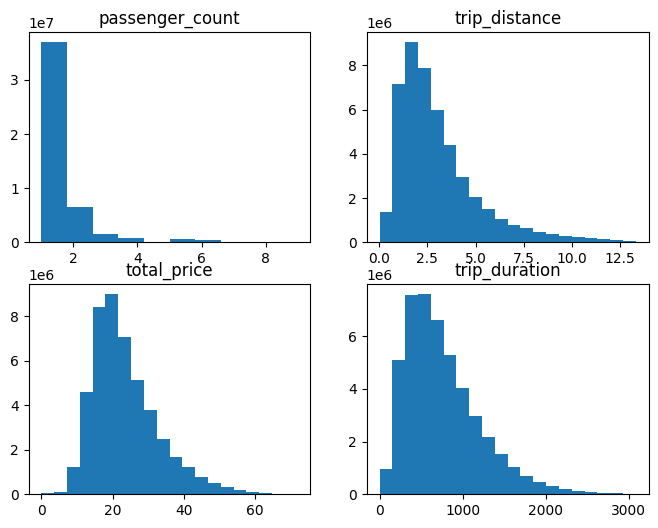

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[0,0].hist(df_withoutliers['passenger_count'])
axs[0,0].set_title('passenger_count')
axs[0,1].hist(df_withoutliers['trip_distance'], bins=20)
axs[0,1].set_title('trip_distance')
axs[1,0].hist(df_withoutliers['total_price'], bins=20)
axs[1,0].set_title('total_price')
axs[1,1].hist(df_withoutliers['trip_duration'], bins=20)
axs[1,1].set_title('trip_duration')


#### 1. Cantidad de Pasajeros (passenger_count):

La mayoría de los viajes realizados en taxis o servicios de viajes compartidos en Nueva York involucran a un solo pasajero, como se observa en la marcada concentración hacia los valores más bajos en el histograma.
La demanda parece inclinarse hacia autos compactos, capaces de transportar de manera eficiente a un solo pasajero o parejas. Sin embargo, podría haber oportunidades en zonas específicas o durante eventos donde los viajes grupales puedan aumentar, lo que justificaría tener algunos vehículos más grandes disponibles.

#### 2. Distancia de Viaje (trip_distance):

La distancia promedio de los viajes tiende a ser corta, con la mayoría de los viajes ubicados por debajo de las 5 millas. Solo una minoría de viajes excede esta distancia, lo que puede reflejar la naturaleza intrínseca de la movilidad urbana, donde los viajes son mayormente locales y los usuarios optan por el taxi para trayectos cortos y rápidos.

#### 3. Tiempo del Viaje (trip_duration):
La duración de los viajes sigue una distribución similar a la distancia, con la mayoría de los trayectos durando menos de 15 minutos. Esto refleja la eficiencia de los servicios en la ciudad, donde las personas prefieren utilizar taxis para movimientos rápidos dentro de Manhattan o sus alrededores. La cola larga de la distribución sugiere la presencia de algunos viajes considerablemente más largos, posiblemente debido a factores como el tráfico o la distancia, especialmente en trayectos fuera del centro urbano.
Estos datos sobre la duración del viaje pueden ayudar a la empresa a planificar mejor los turnos de los conductores y la rotación de vehículos, así como a prever los períodos de inactividad entre los viajes.

#### 4. Precio Total (total_price):
La distribución del precio total muestra una mayoría de viajes con un costo moderado, entre $10 y $30. No obstante, algunos viajes alcanzan tarifas considerablemente más altas, lo que podría correlacionarse con viajes más largos o en horarios de alta demanda. La relación entre distancia y precio es predecible, aunque también podría haber fluctuaciones debido a factores como tarifas dinámicas o tiempos prolongados debido a congestiones de tráfico.

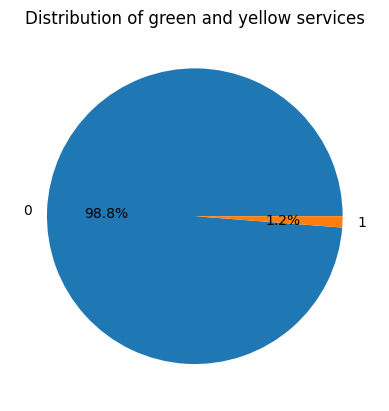

In [8]:
counts = df_withoutliers['service'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title('Distribution of green and yellow services')
plt.show()


Existe un claro desbalanceo de clases entre los taxis que realizan viajes por fuera del distrito de Manhattan, lo que podria llegar a complicar a la hora de predecir la cantidad de viajes intra e inter distrito.

## 1.1 Correlation


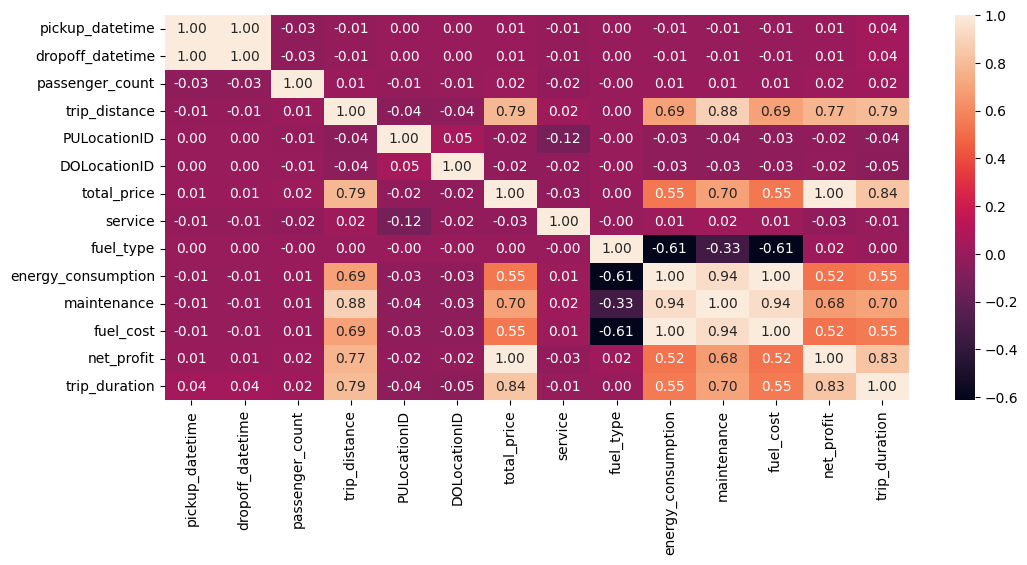

In [9]:
corr = df_withoutliers.corr(method='spearman')
plt.figure(figsize=(12,5))
sns.heatmap(data=corr,annot=True,fmt='.2f')
plt.show()

## 1.2 Time Series

In [ ]:
# Extraer año, trimestre, mes, día del mes, día de la semana y hora
df['year'] = df['pickup_datetime'].dt.year
df['quarter'] = df['pickup_datetime'].dt.quarter
df['month'] = df['pickup_datetime'].dt.month
df['day_month'] = df['pickup_datetime'].dt.day
df['weekday'] = df['pickup_datetime'].dt.day_name()
df['hour'] = df['pickup_datetime'].dt.hour
#df.drop(columns=['pickup_datetime','dropoff_datetime'],inplace=True)